# Credit Card Defaults

## Data Preprocessing


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import utils

In [2]:
# Load the data
df = pd.read_csv('../data/UCI_Credit_Card.csv')
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [3]:
# Split the data into features and target
X = df.drop(columns=['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

In [4]:
# Check for missing values
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [5]:
# Check for duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis

In [6]:
# Describe the data
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


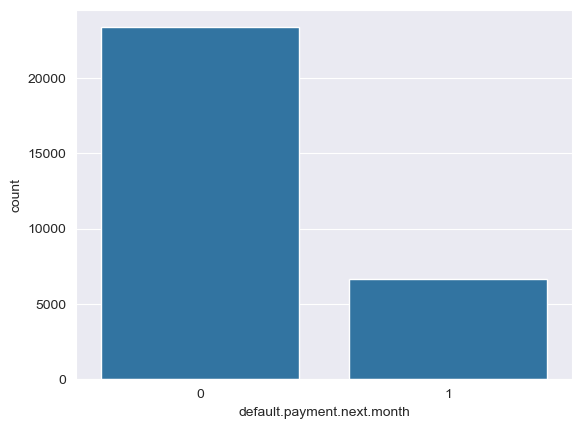

In [7]:
 # plot the distribution of the target variable
sns.countplot(x='default.payment.next.month', data=df)
plt.show()

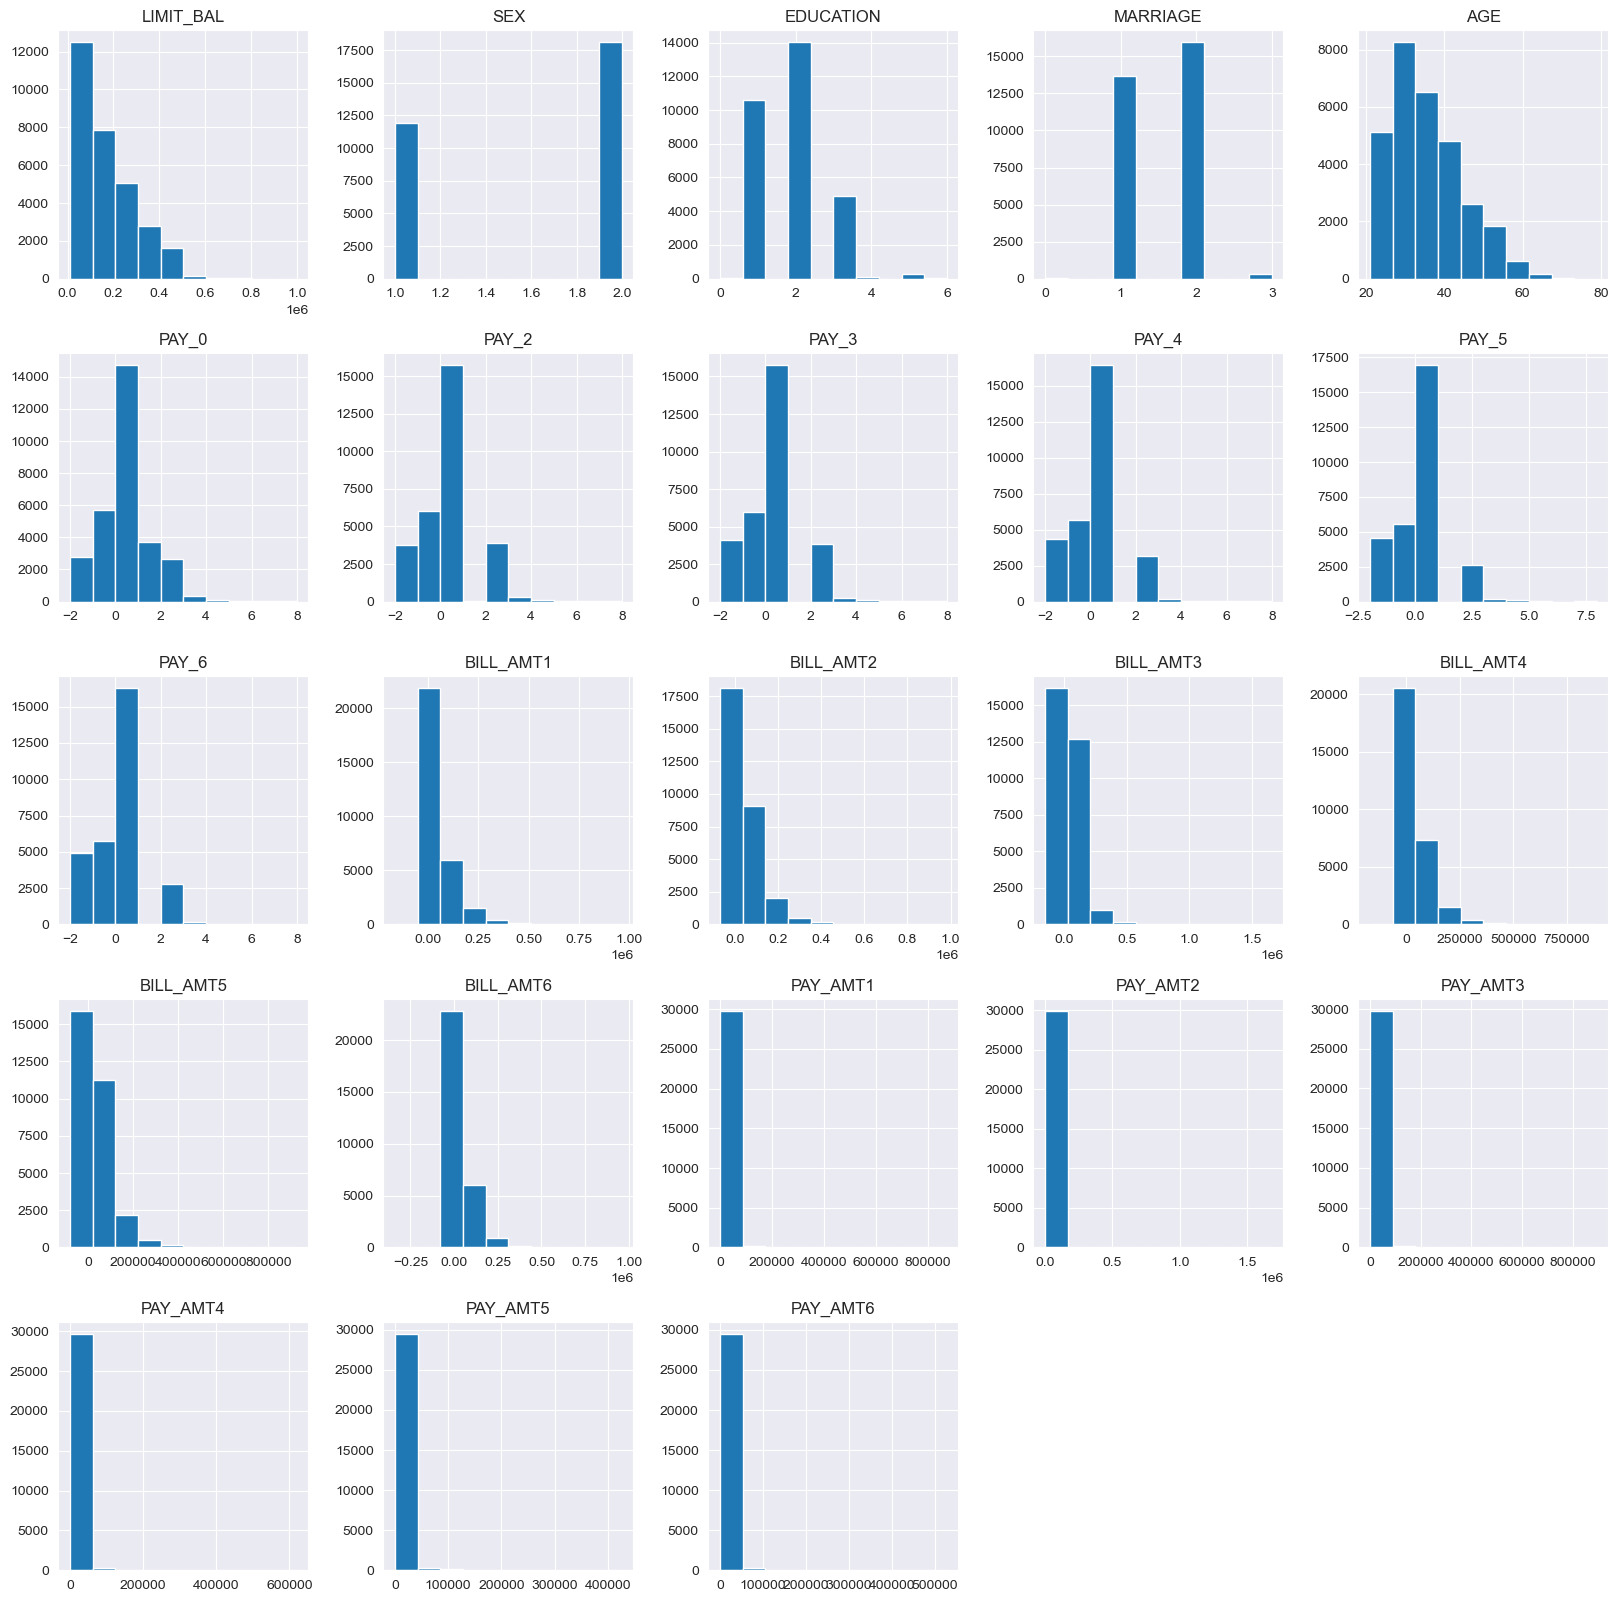

In [8]:
# plot the distribution of the features
X.hist(figsize=(20, 20))
plt.show()

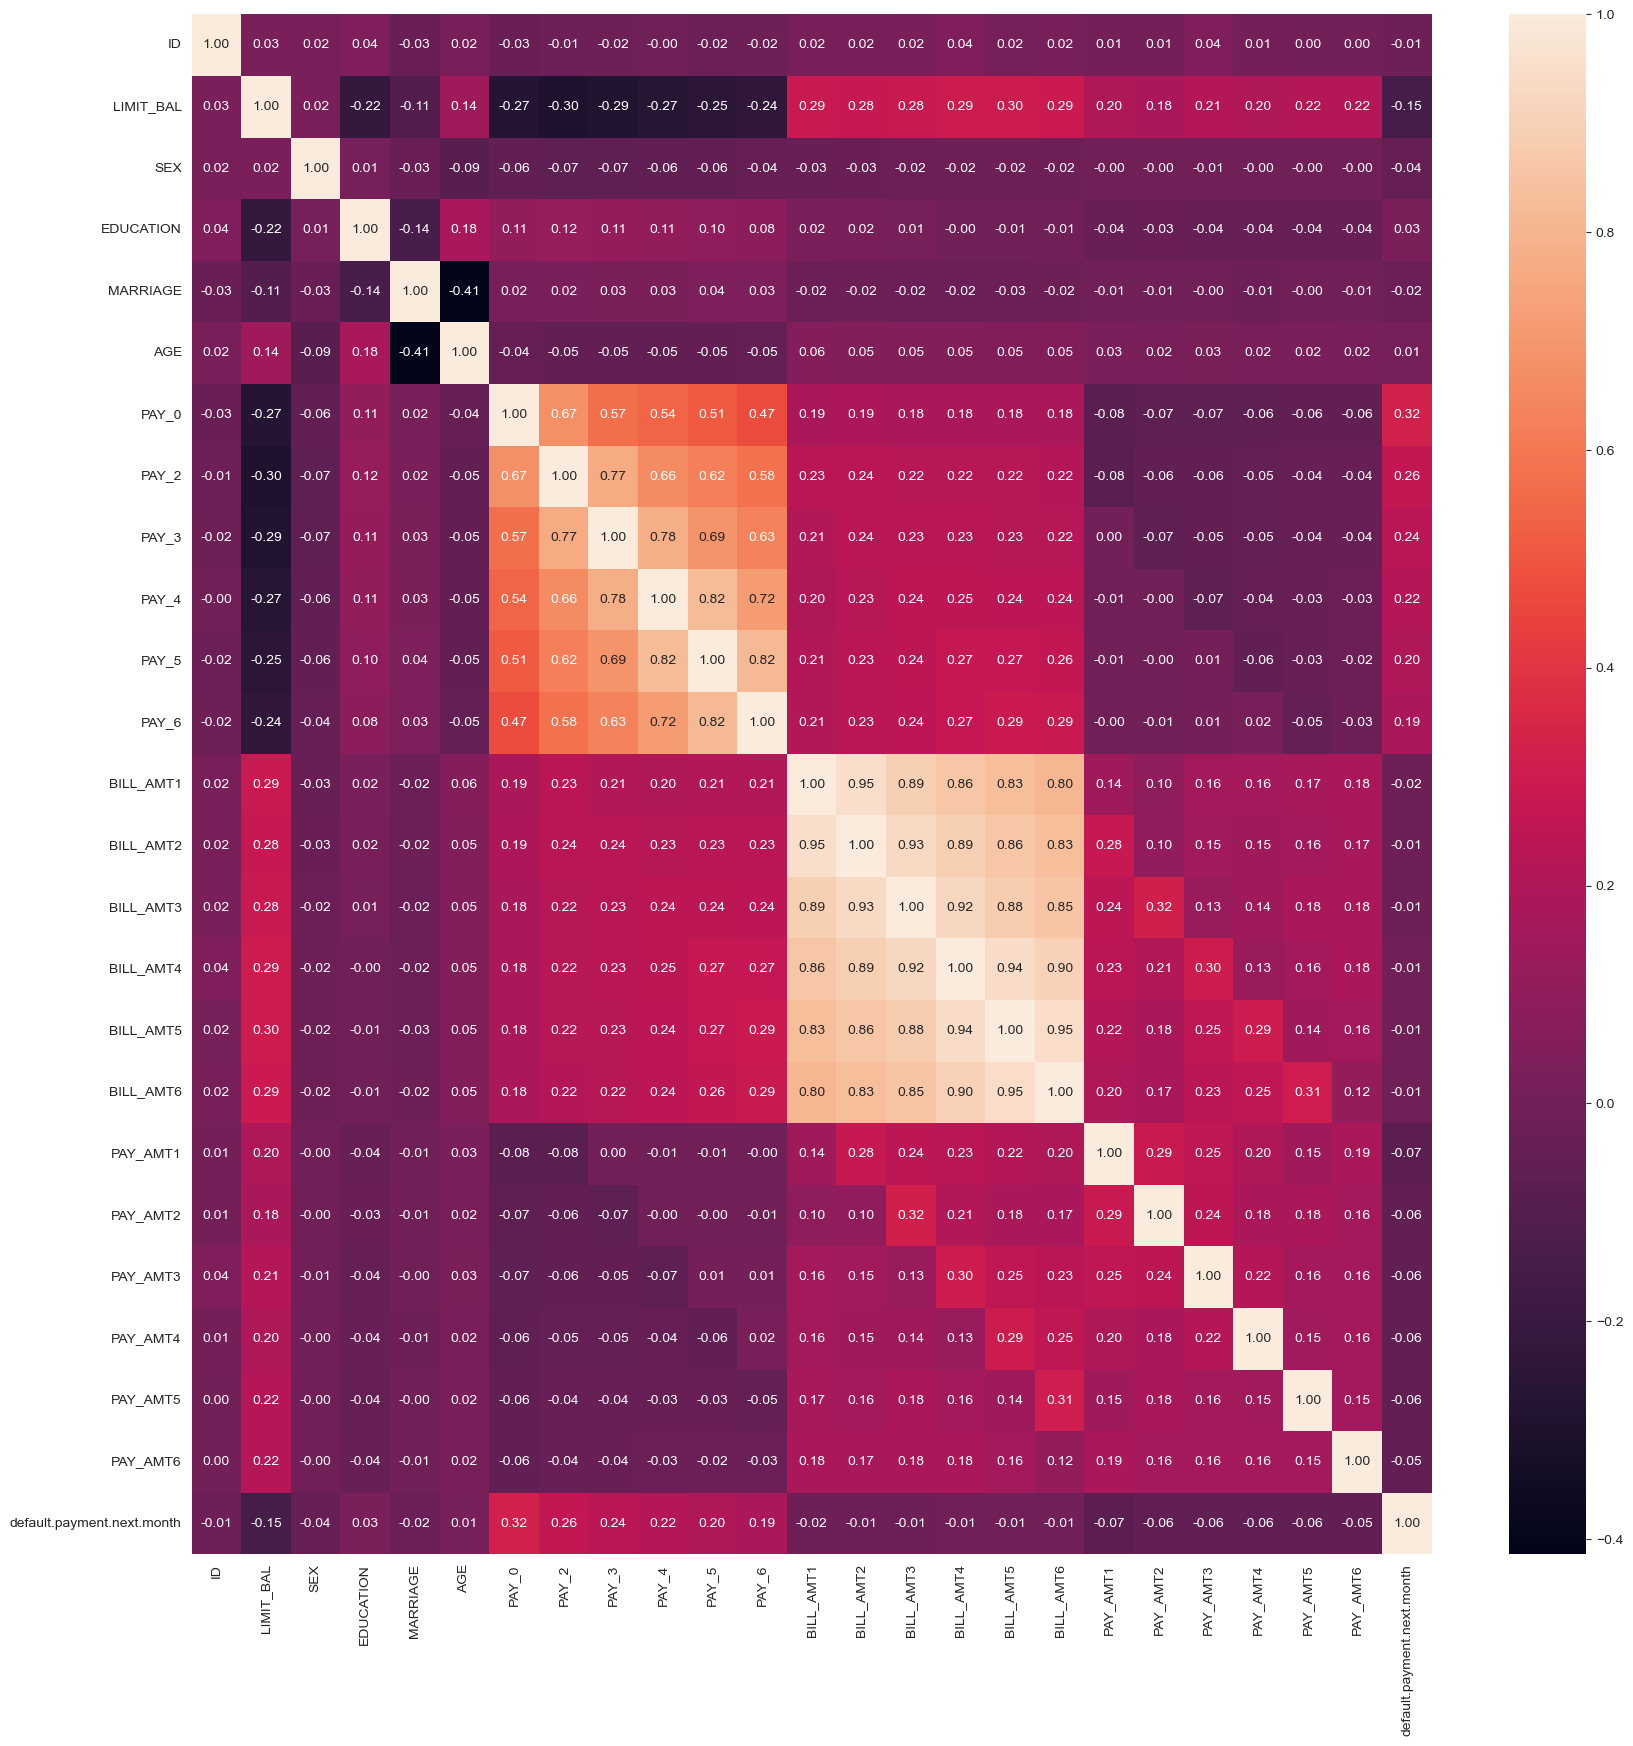

In [9]:
# plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

## Feature Engineering

### Remove Highly Correlated Features

In [10]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X)
X_vif

Removed variables with high VIF:
BILL_AMT2: 38.214224700379255
BILL_AMT5: 35.97887400382354
BILL_AMT3: 24.116020633648667
BILL_AMT4: 15.178646004881054
AGE: 10.857340872567654


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,2,2,-1,-1,-2,-2,3913.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,-1,2,0,0,0,2,2682.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,0,0,0,0,0,0,29239.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,0,0,0,0,0,0,46990.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,-1,0,-1,0,0,0,8617.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,0,0,0,0,0,0,188948.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,150000.0,1,3,2,-1,-1,-1,-1,0,0,1683.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,30000.0,1,2,2,4,3,2,-1,0,0,3565.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,80000.0,1,3,1,1,-1,0,0,0,-1,-1645.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


### Split the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.1, random_state=42, shuffle=True)

In [12]:
# Further split training data into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

### Standardization

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled array back to DataFrame with original column names
X_train_scaled_res_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

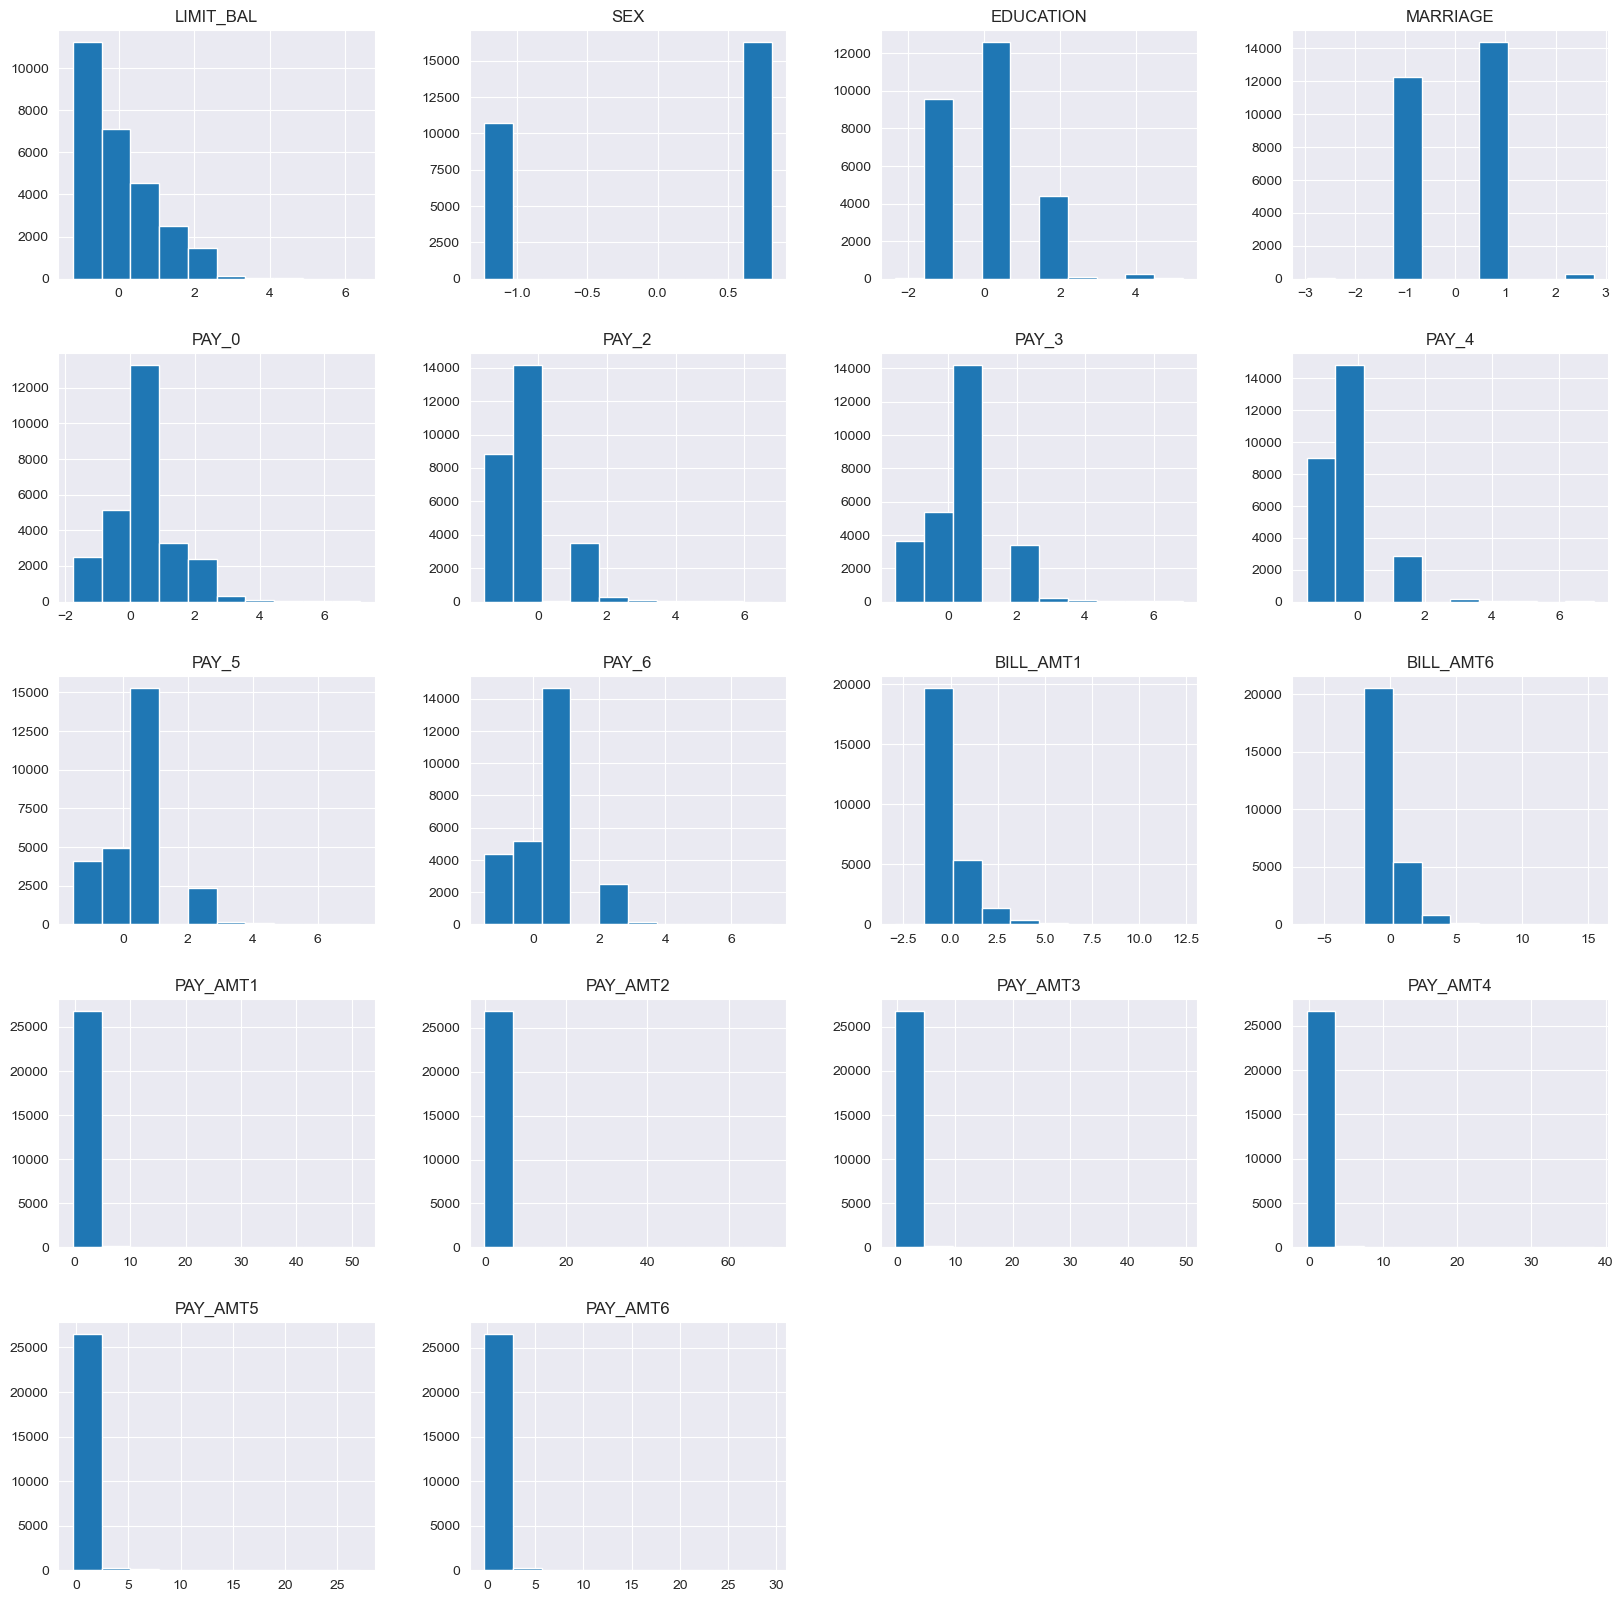

In [14]:
# Plot the distribution of the scaled features
pd.DataFrame(X_train_scaled_res_df).hist(figsize=(20, 20))
plt.show()

## Model Selection

### Logistic Regression

In [15]:
# use logit regression as the model

# Reset the index of y_train to match X_train_scaled_const
y_train_scaled = y_train.reset_index(drop=True)

# Add a constant for the intercept
X_train_scaled_const = sm.add_constant(X_train_scaled_res_df)

logit_model = sm.Logit(y_train_scaled, X_train_scaled_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.465025
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                27000
Model:                                  Logit   Df Residuals:                    26981
Method:                                   MLE   Df Model:                           18
Date:                        Sun, 29 Sep 2024   Pseudo R-squ.:                  0.1203
Time:                                17:18:39   Log-Likelihood:                -12556.
converged:                               True   LL-Null:                       -14273.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4594      0.017    -84.125 

In [16]:
# evaluate the model
X_test_scaled_const = sm.add_constant(X_test_scaled_df)
y_pred_prob = logit_model.predict(X_test_scaled_const)  # Predicted probabilities for test data
y_pred_logit = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

### Random Forest

In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# evaluate the model
y_pred_rf = rf_model.predict(X_test)

### XGBoost

In [19]:
# use xgboost as the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
# evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

#### Hyperparameter Tuning

In [21]:
# use grid search to find the best hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'learning_rate': [0.01, 0.05, 0.1],  # Shrinkage step size
    'max_depth': [3, 5, 7],  # Max depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum child weight
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction to split
    'subsample': [0.8, 1.0],  # Subsample ratio of the training data
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight': [1, 5, 10],  # Balancing class weight for imbalance
}

In [22]:
# Define a custom scorer
scorer = make_scorer(f1_score)

In [23]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=2)

grid_search.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=False)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 5, 10],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

In [25]:
# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'scale_pos_weight': 5, 'subsample': 0.8}
Best Score:  0.5264204732543387


In [26]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper = grid_search.predict(X_test)

## Model Evaluation

### Logistic Regression

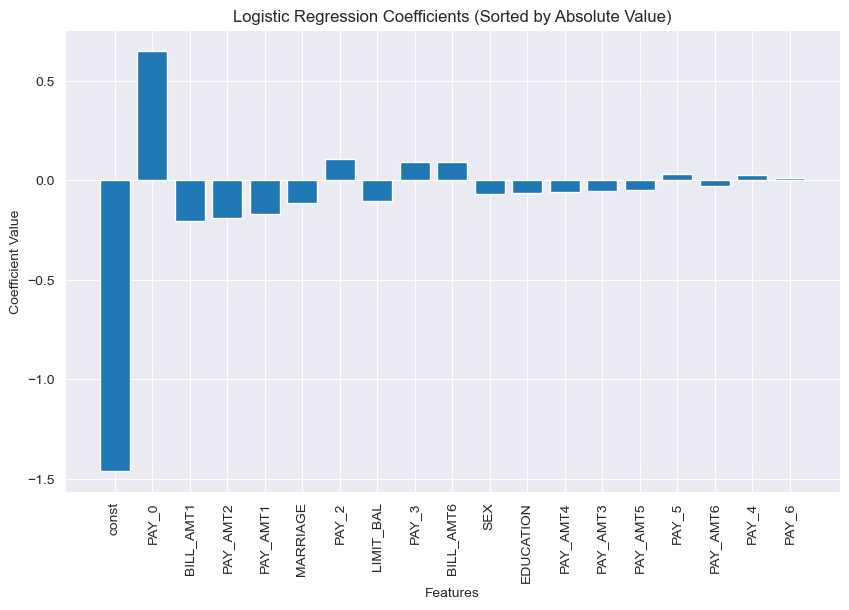

In [27]:
# Extract the coefficients
coefficients = logit_model.params

# Sort the coefficients by their absolute values
sorted_coefficients = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

# Extract the feature names
sorted_features = sorted_coefficients.index.tolist()

# Plot the sorted feature names
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_coefficients)
plt.title('Logistic Regression Coefficients (Sorted by Absolute Value)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

In [28]:
accuracy = accuracy_score(y_test, y_pred_logit)
print("Accuracy:", accuracy)

Accuracy: 0.8086666666666666


In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_logit)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2274   67]
 [ 507  152]]


In [30]:
# use classification report
class_report = classification_report(y_test, y_pred_logit)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2341
           1       0.69      0.23      0.35       659

    accuracy                           0.81      3000
   macro avg       0.76      0.60      0.62      3000
weighted avg       0.79      0.81      0.77      3000



This model is doing a good job predicting when people are not going to default on their credit cards, but it is doing a poor job of predicting when people are going to default on their credit cards. The model has a high precision and recall for the negative class, but a low precision and recall for the positive class.

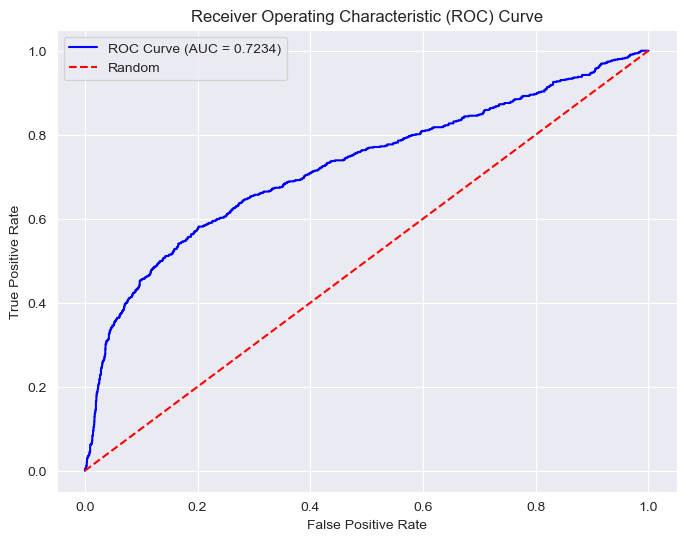

In [31]:
# plot roc curve
utils.plot_roc_curve(y_test, y_pred_prob)

### Random Forest

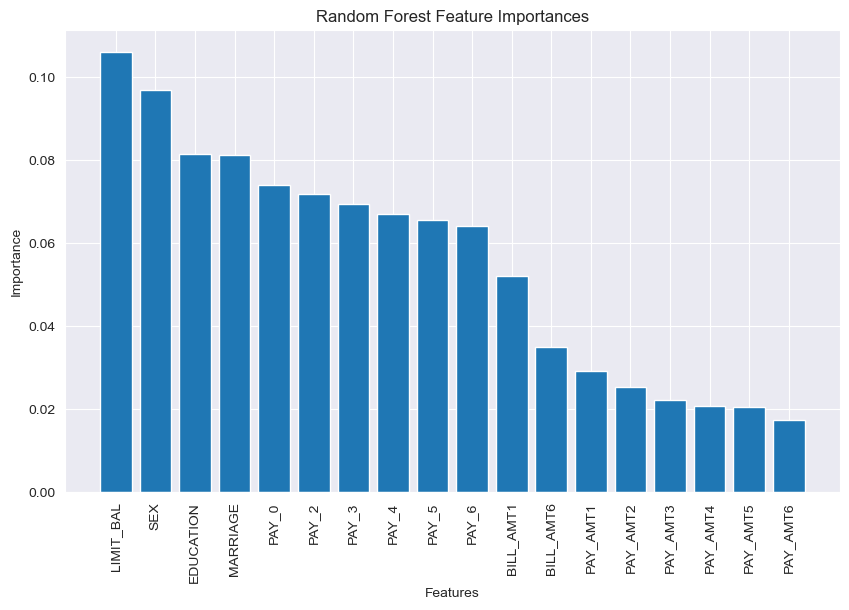

In [50]:
# plot the feature importances

# Extract the feature importances
feature_importances = rf_model.feature_importances_

# Sort the feature importances
sorted_indices = feature_importances.argsort()[::-1]
feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In [51]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.8166666666666667


In [52]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2199  142]
 [ 408  251]]


In [53]:
# use classification report
class_report = classification_report(y_test, y_pred_rf)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2341
           1       0.64      0.38      0.48       659

    accuracy                           0.82      3000
   macro avg       0.74      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000



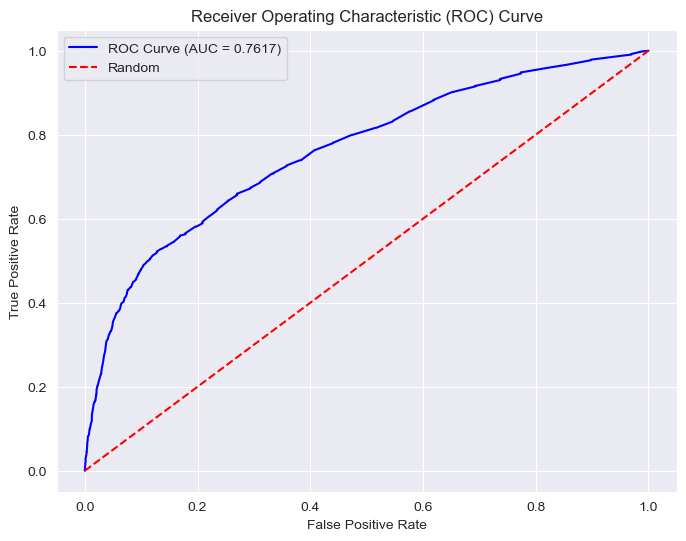

In [54]:
# plot roc curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob)

### XGBoost

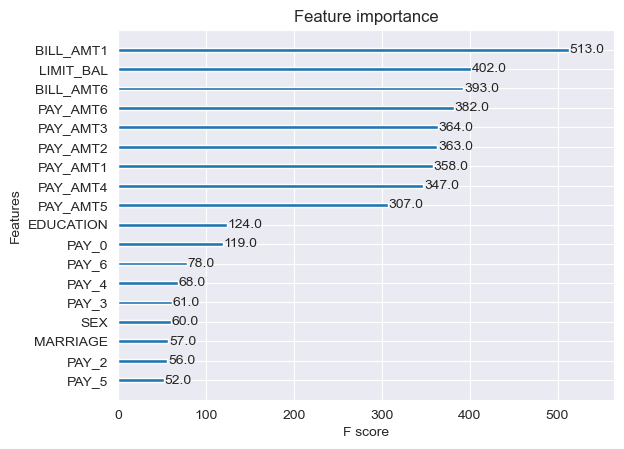

In [37]:
# plot the feature importances
xgb.plot_importance(xgb_model)
plt.show()

In [47]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2191  150]
 [ 416  243]]


In [38]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.8113333333333334


In [39]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2341
           1       0.62      0.37      0.46       659

    accuracy                           0.81      3000
   macro avg       0.73      0.65      0.67      3000
weighted avg       0.79      0.81      0.79      3000



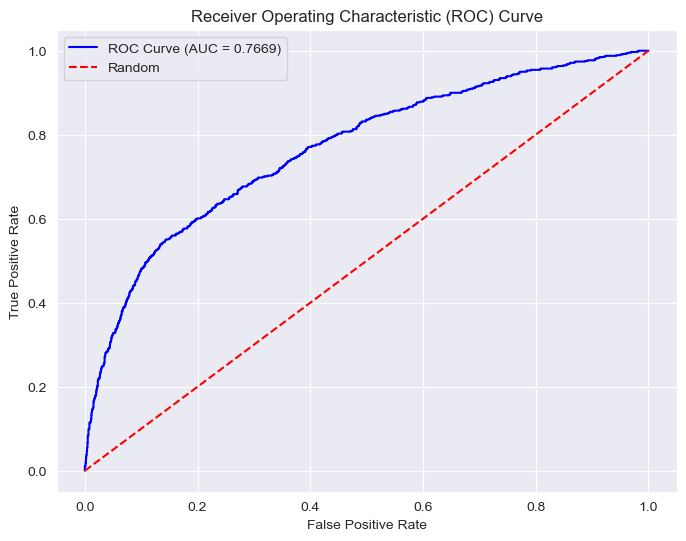

In [40]:
# plot roc curve
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob)

### XGBoost with Hyperparameter Tuning

In [44]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.725


In [48]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1724  617]
 [ 208  451]]


In [45]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      2341
           1       0.42      0.68      0.52       659

    accuracy                           0.72      3000
   macro avg       0.66      0.71      0.66      3000
weighted avg       0.79      0.72      0.74      3000



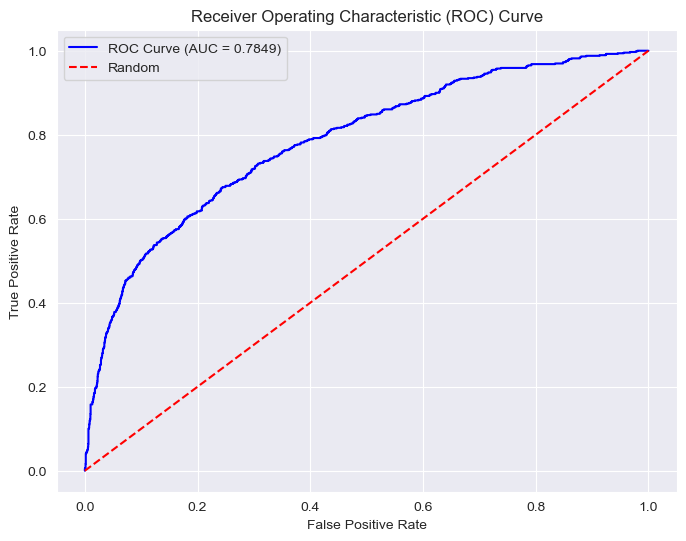

In [46]:
# plot roc curve
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob)